### Import libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from itertools import chain
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import itertools 
import itertools as itert
from operator import itemgetter
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.flow import shortest_augmenting_path
import statistics as stat
import collections
import time

### Edge Cut Set
####  This function find edges that connect the component cnp to the rest of graph.

In [2]:
def edgeCutSet_V2(cnp , G):
    
    edge_cnp = cnp.edges()
    edge_G = G.edges(cnp.nodes())
    edgeSet = list(edge_G - edge_cnp)
    return(edgeSet)

### Cut Nodes
#### This function finds nodes with minimum degree and removes their neighbors of this node from G

**Reason:** The maximum value of k-connectivity of a graph is equal to minimum degree of the given graph.

In [3]:
def _is_separating_set(G, cut):
    """Assumes that the input graph is connected and return TRUE if removing cut from
        the input graph makes it disconnected."""
    if len(cut) == len(G) - 1:
        return True
    H = G.copy()
    H.remove_nodes_from(cut)
    if nx.is_connected(H):
        return False
    return True

In [4]:
def my_cut_nodes(G,mixed_label = False):
    cut_node = []
    degree = G.degree()
    sorted_nodes = sorted(degree, key=itemgetter(1), reverse=True)
    #-----if we have articulation point----------------------
    articu_points = list(nx.articulation_points(G))
    if articu_points:
        [cut_node.append([v]) for v in articu_points]
        return(cut_node)
    #----------------------------------------------------------
    #-------Find all nodes with delta degree and remove their neighbors
    delta = sorted_nodes[-1][1]
    X = [n for n, d in sorted_nodes[:delta]]
    if _is_separating_set(G, X):
        cut_node.append(X)
    node_deltaDegree = [j[0] for i,j in enumerate(degree) if j[1]==delta]
    for n in node_deltaDegree:
        cut_node.append(list(G.neighbors(n)))
    if not mixed_label:
        cut_node_set = set(tuple(sorted(x)) for x in cut_node)
        cut_node = [ list(x) for x in cut_node_set ]
    else:
        sorted_x = []
        for i in range(len(cut_node)):
            intList=sorted([i for i in cut_node[i] if type(i) is int])
            strList=sorted([i for i in cut_node[i] if type(i) is str])
            sorted_x.append(intList + strList) 
        cut_node =  list(set(tuple(i) for i in (sorted_x)))
    return(cut_node)

### Coherent Cut Ratio or Score
**Score should be minimum**

I concider Clustering coefficient and the ratio between the number of edges inside the partition and the ones which connect the partition to the rest of graph

In [5]:
def coherentCutRatio_V1(deg_cnp, deg_G):
    deg_cnp = [di[1] for di in deg_cnp] #change the set to list
    deg_G = [dg[1] for dg in deg_G] #change the degree set to list
    if sum(deg_cnp)==0:
         score = 100
    else:
        score = sum(deg_G)/sum(deg_cnp)
    return(score)  

In [6]:
#compute ratio of coherent cut which needs to be minimum
def coherentCutRatio_V4(deg_cnp, deg_G,cluster_coef):
    deg_cnp = [di[1] for di in deg_cnp] #change the set to list
    deg_G = [dg[1] for dg in deg_G] #change the degree set to list
    if sum(deg_cnp)==0:
        score = 100
    else:
        r = (sum(deg_G)/sum(deg_cnp)) - 1
        if cluster_coef!=0:
            score = r/cluster_coef
    return(score)  

### PC2P function
This function returns set of edges whose removal from the original graph, will give all the partitions.

In [7]:
def Find_CNP(G, mixed_label = False):
    #Find all component of G
    G_components = list(nx.connected_components(G))
    G_temp = G.copy()
    edge_cut = []
    while len(G_components) != 0:
        min_ratioN1 = 1000
        min_ratioN2 = 1000
        componentOfG = G.subgraph(G_components[0]).copy() #we get the first component and find cnp
        if len(componentOfG.nodes())==1 or len(componentOfG.nodes())==2 or len(componentOfG.nodes())==3:
            del G_components[0]
            continue
        for v in G_components[0]:
            neighbor1 = list(componentOfG.neighbors(v))
            neighbor1.extend([v])
            induced_N1 = componentOfG.subgraph(neighbor1)
            #----------- Clustering Coefficient
            length_n1 = len(neighbor1)
            length_e1 = len(list(induced_N1.edges()))
            if length_n1==1 or length_n1==0:
                cc=0
            else:
                cc = 2*length_e1/(length_n1*(length_n1-1))
            #-----Calculating clustering coefficient is finished here!-------
            cutRatioN1_V4 = coherentCutRatio_V4(nx.degree(induced_N1),nx.degree(componentOfG,induced_N1.nodes()),cc)
            cutRatioN1_V1 = coherentCutRatio_V1(nx.degree(induced_N1),nx.degree(componentOfG,induced_N1.nodes()))
            cutRatioN1 = stat.mean([cutRatioN1_V4,cutRatioN1_V1])
            if cutRatioN1 < min_ratioN1:
                min_ratioN1 = cutRatioN1
                #calculate edge cut for this minimum cut ratio
                cnp_nodes1 = induced_N1.nodes()
                edge_cutN1 = edgeCutSet_V2(induced_N1,componentOfG)
                minN1_v4 = cutRatioN1_V4
                minN1_v1 = cutRatioN1_V1
            #Get neighbor2 for node v
            neighbor2 = neighbor1[:]
            [neighbor2.extend(list(componentOfG.neighbors(n))) for n in neighbor1]
            neighbor2 = list(set(neighbor2))
            induced_N2 = componentOfG.subgraph(neighbor2).copy()
            induced_N2 = induced_N2.copy()
            Complement_indN2 = nx.complement(induced_N2)
            if(not nx.is_connected(Complement_indN2)):#we find the CNP
                #----------- Clustering Coefficient
                length_n2 = len(neighbor2)
                length_e2 = len(list(induced_N2.edges()))
                if length_n2==1 or length_n2==0:
                    cc=0
                else:
                    cc = 2*length_e2/(length_n2*(length_n2-1))
                #-----Calculating clustering coefficient is finished here!-------
                cutRatioN2_V4 = coherentCutRatio_V4(nx.degree(induced_N2),nx.degree(componentOfG,induced_N2.nodes()),cc)
                cutRatioN2_V1 = coherentCutRatio_V1(nx.degree(induced_N2),nx.degree(componentOfG,induced_N2.nodes()))
                cutRatioN2 = stat.mean([cutRatioN2_V4,cutRatioN2_V1])
                if cutRatioN2 < min_ratioN2:
                    min_ratioN2 = cutRatioN2
                    #calculate edge cut for this minimum cut ratio
                    cnp_nodes2 = induced_N2.nodes()
                    edge_cutN2 = edgeCutSet_V2(induced_N2,componentOfG)
                    minN2_v4 = cutRatioN2_V4
                    minN2_v1 = cutRatioN2_V4
            else:
                cut_node = my_cut_nodes(Complement_indN2, mixed_label)
                if (len(cut_node)==0):
                    print("for node ",v,"removing ",cut_node," is not enough and we need to remove more than K nodes")
                    return
                """"we may find differnt cut_node_set 
                    if we have more than one choose a set with minimum weight"""
                if (len(cut_node)>1): 
                    minweight = 1000
                    for n in cut_node:
                        """we calculate the score for each set seperately and then choose one with the minimum score"""
                        temp_N2 = induced_N2.copy()
                        temp_N2.remove_nodes_from(n)
                        #----------- Clustering Coefficient
                        length_n2 = len(temp_N2.nodes())
                        length_e2 = len(list(temp_N2.edges()))
                        if length_n2==1 or length_n2==0:
                            cc=0
                        else:
                            cc = 2*length_e2/(length_n2*(length_n2-1))
                        #-----Calculating clustering coefficient is finished here!-------
                        cutRatioN2_V4 = coherentCutRatio_V4(nx.degree(temp_N2),nx.degree(componentOfG,temp_N2.nodes()),cc)
                        cutRatioN2_V1 = coherentCutRatio_V1(nx.degree(temp_N2),nx.degree(componentOfG,temp_N2.nodes()))
                        temp_score = stat.mean([cutRatioN2_V4,cutRatioN2_V1])
                        if temp_score < minweight:
                            minweight = temp_score
                            minWeightNode = n
                    cut_node = minWeightNode
                else:
                    #flatten the cut node
                    cut_node = [node for sublist in cut_node for node in sublist]
                induced_N2.remove_nodes_from(cut_node)
                #----------- Clustering Coefficient
                length_n2 = len(induced_N2.nodes())
                length_e2 = len(list(induced_N2.edges()))
                if length_n2==1 or length_n2==0:
                    cc=0
                else:
                    cc = 2*length_e2/(length_n2*(length_n2-1))
                #-----Calculating clustering coefficient is finished here!-------
                cutRatioN2_V4 = coherentCutRatio_V4(nx.degree(induced_N2),nx.degree(componentOfG,induced_N2.nodes()),cc)
                cutRatioN2_V1 = coherentCutRatio_V1(nx.degree(induced_N2),nx.degree(componentOfG,induced_N2.nodes()))
                cutRatioN2 = stat.mean([cutRatioN2_V4,cutRatioN2_V1])
                if cutRatioN2 < min_ratioN2:
                    min_ratioN2 = cutRatioN2
                    #calculate edge cut for this minimum cut ratio
                    cnp_nodes2 = induced_N2.nodes()
                    edge_cutN2 = edgeCutSet_V2(induced_N2,componentOfG)
                    minN2_v4 = cutRatioN2_V4
                    minN2_v1 = cutRatioN2_V4
        if min_ratioN1 < min_ratioN2:
            edge_cut.append(edge_cutN1)
            cnp_nodes = cnp_nodes1
        else:
            edge_cut.append(edge_cutN2)
            cnp_nodes = cnp_nodes2
        G_temp.remove_nodes_from(cnp_nodes)
        G_components = list(nx.connected_components(G_temp))
    edge_cut = [edge for sublist in edge_cut for edge in sublist]
    if not mixed_label:
        edge_cut = list(set(tuple(sorted(x)) for x in edge_cut))
    else:
        sorted_x = []
        for i in range(len(edge_cut)):
            intList=sorted([i for i in edge_cut[i] if type(i) is int])
            strList=sorted([i for i in edge_cut[i] if type(i) is str])
            sorted_x.append(intList + strList) 
        edge_cut =  list(set(tuple(i) for i in (sorted_x)))
    return(edge_cut)

### Examples

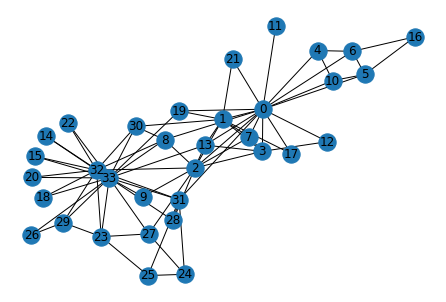

number of removed edges is:  19


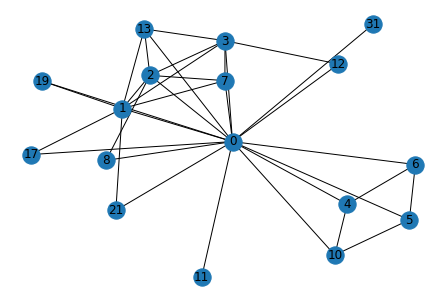

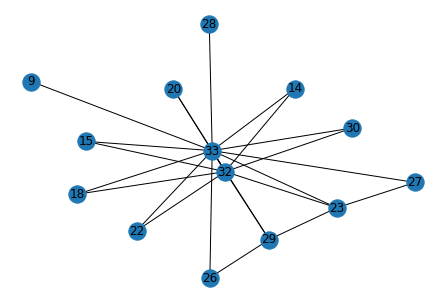

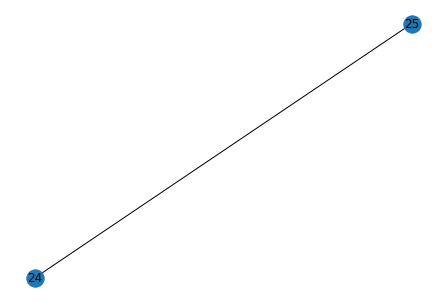

In [29]:
G = nx.karate_club_graph()
nx.draw(G,with_labels=True)
plt.show()
karate_edge = Find_CNP(G)
print("number of removed edges is: ",len(karate_edge))
pc2p = G.copy()
pc2p.remove_edges_from(karate_edge)
cmps = nx.connected_components(pc2p)

for cmp in cmps:
    s = G.subgraph(cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True)
        plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


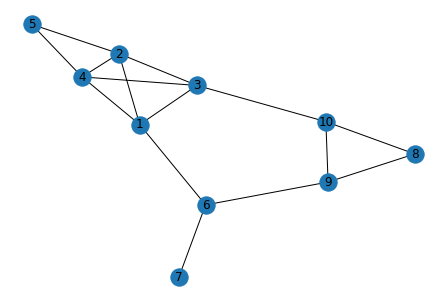

number of removed edges is:  3


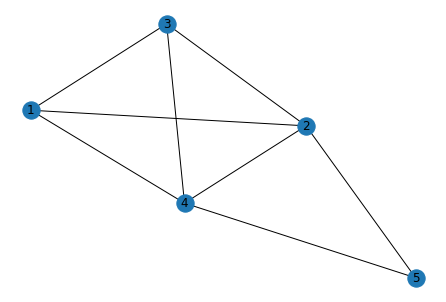

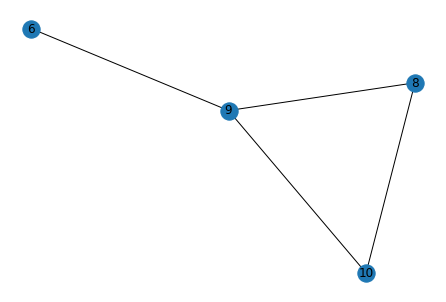

In [28]:
edges = [(1,2),(1,3),(1,4),(1,6),(2,3),(2,4),(2,5),(3,4),(3,10),(4,5),(6,7),(6,9),(8,9),(8,10),(9,10)]
# c = list(map(chr, range(97, 102)))

nodes = list(range(1,11)) 
print(nodes)
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,with_labels=True)
plt.show()

e = Find_CNP(G)
print("number of removed edges is: ",len(e))

pc2p = G.copy()
pc2p.remove_edges_from(e)
cmps = nx.connected_components(pc2p)
for cmp in cmps:
    s = G.subgraph(cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True )
        plt.show()

C:\Users\somranian\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


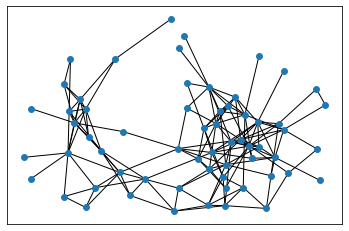

number of removed edges is:  68


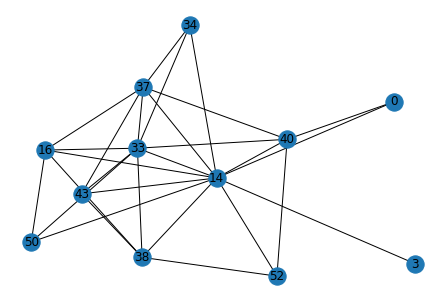

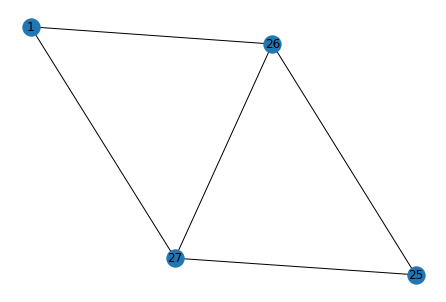

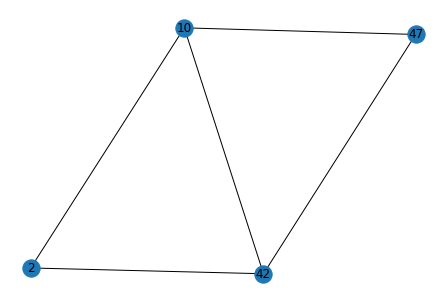

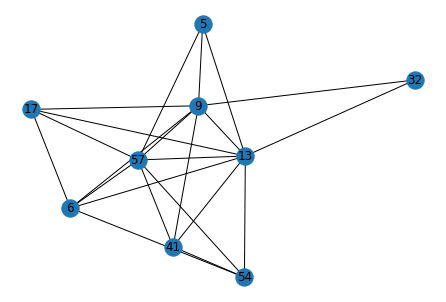

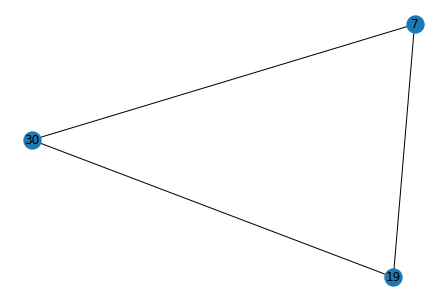

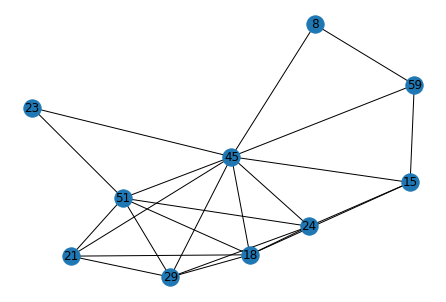

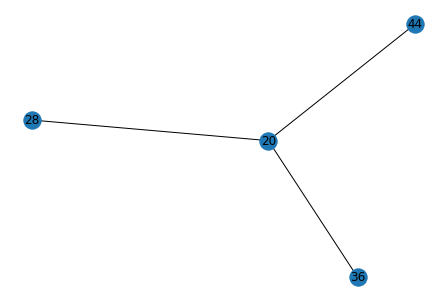

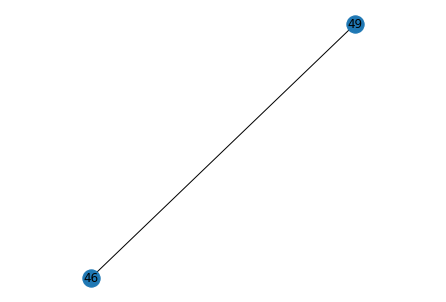

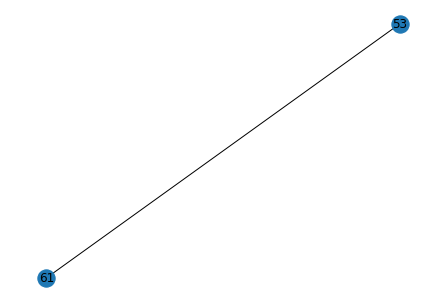

In [27]:
DolphinGraph = nx.read_gml("dolphins/dolphins.gml")
labels = {}
for idx, node in enumerate(DolphinGraph.nodes()):
    labels[node] = idx
DolphinGraph = nx.relabel_nodes(DolphinGraph,labels)
# Create network layout for visualizations
spring_pos = nx.spring_layout(DolphinGraph)
nx.draw_networkx(DolphinGraph, pos = spring_pos, with_labels = False, node_size = 35)
plt.show()
edge_Dolphin = Find_CNP(DolphinGraph)
print("number of removed edges is: ",len(edge_Dolphin))

pc2p = DolphinGraph.copy()
pc2p.remove_edges_from(edge_Dolphin)
cmps = nx.connected_components(pc2p)
for cmp in cmps:
    s = DolphinGraph.subgraph(cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True)
        plt.show()

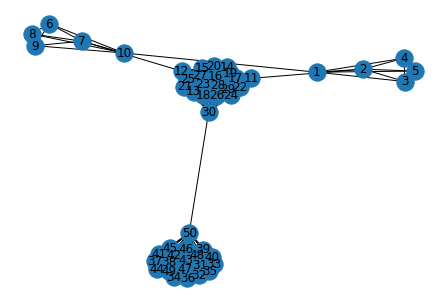

number of removed edges is:  4


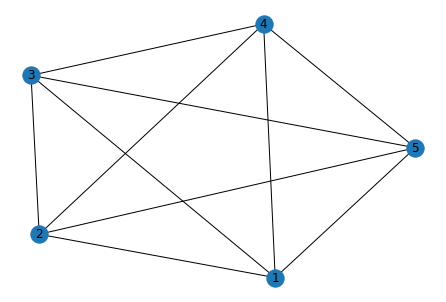

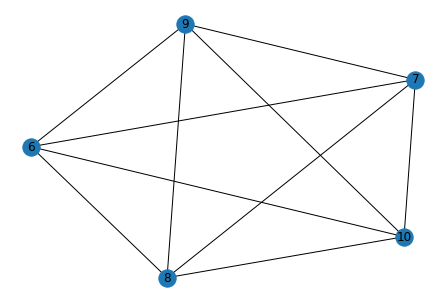

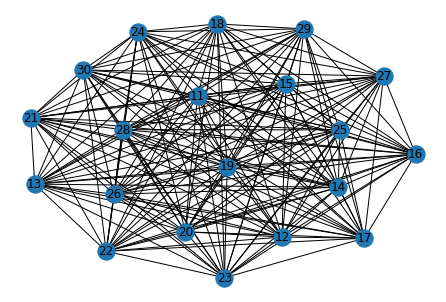

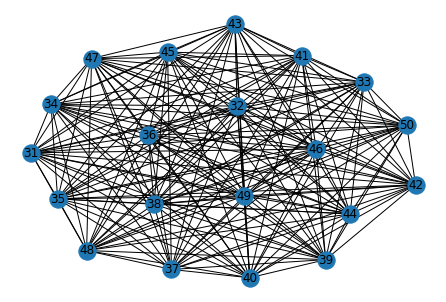

In [57]:
n1 = list(range(1,6))
G_5_1 = nx.Graph()
G_5_1.add_edges_from(itertools.combinations(n1,2))

n2 = list(range(6,11))
G_5_2 = nx.Graph()
G_5_2.add_edges_from(itertools.combinations(n2,2))

n3 = list(range(11,31))
G_20_1 = nx.Graph()
G_20_1.add_edges_from(itertools.combinations(n3,2))

n4 = list(range(31,51))
G_20_2 = nx.Graph()
G_20_2.add_edges_from(itertools.combinations(n4,2))

G_5 =nx.compose(G_5_1,G_5_2)
G_5.add_edges_from([(1,10)])

G_20 =nx.compose(G_20_1,G_20_2)
G_20.add_edges_from([(30,50)])

G = nx.compose(G_5,G_20)
G.add_edges_from([(11,2),(12,7)])
nx.draw(G,with_labels=True)
plt.show()

e = Find_CNP(G)

print("number of removed edges is: ",len(e))

pc2p = G.copy()
pc2p.remove_edges_from(e)
cmps = nx.connected_components(pc2p)
for cmp in cmps:
    s = G.subgraph(cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True)
        plt.show()

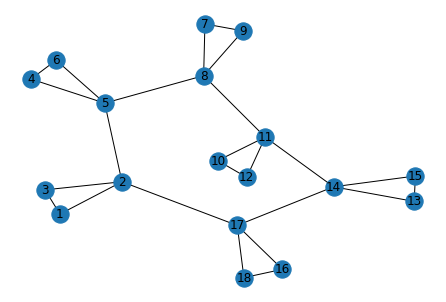

number of removed edges is:  6


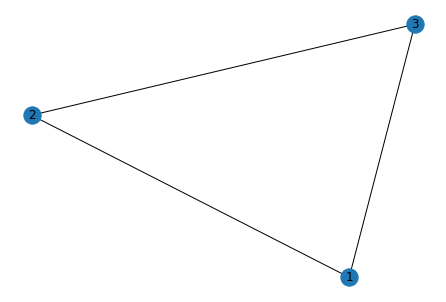

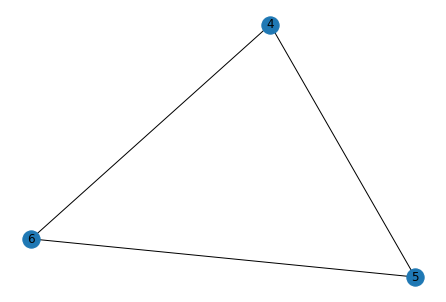

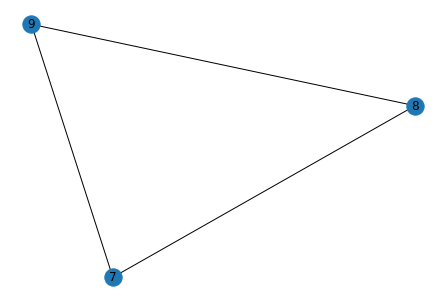

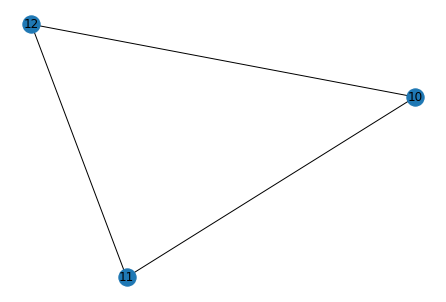

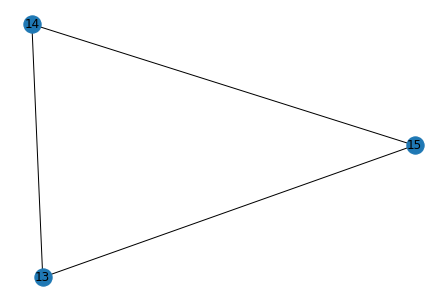

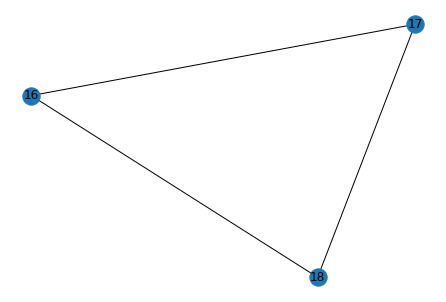

In [58]:
edges = [(1,2), (1,3),(2,3),(2,17),(2,5),(4,5),(4,6),(5,6),(5,8),(7,8),(7,9),(8,9),(8,11),(10,11),(10,12),(11,12),(11,14),(13,14),
         (13,15),(14,15),(14,17),(16,17),(16,18),(17,18)]
nodes = list(range(1,19)) 
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G,with_labels=True)
plt.show()

e = Find_CNP(G)
print("number of removed edges is: ",len(e))

pc2p = G.copy()
pc2p.remove_edges_from(e)
cmps = nx.connected_components(pc2p)
for cmp in cmps:
    s = G.subgraph(cmp)
    if len(s)>= 2:
        nx.draw(s,with_labels = True)
        plt.show()